# $ Panoptic \space Segmentation $
---
User Name : 2ineddine



I. Environment Setup



In [1]:
# Uninstall current versions (just for safety)
!pip uninstall -y torch torchvision torchaudio

# Install PyTorch 1.13.1 (compatible version)
#!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1

# Install Detectron2 compatible with this version
!pip install git+https://github.com/facebookresearch/detectron2.git

# Clone Mask2Former repository (if not already done)
!rm -rf Mask2Former  # remove old folder if necessary
!git clone https://github.com/facebookresearch/Mask2Former.git

!pip install git+https://github.com/cocodataset/panopticapi.git

# Add Mask2Former to Python path
import sys
sys.path.append("./Mask2Former")

# Compile MultiScaleDeformableAttention
%cd Mask2Former/mask2former/modeling/pixel_decoder/ops
!pip install torch
!bash make.sh
%cd ../../../../..


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-q7e0mv62
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-q7e0mv62
  Resolved https://github.com/facebookresearch/detectron2.git to commit 536dc9d527074e3b15df5f6677ffe1f4e104a4ab
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (

II. Download COCO 2017 Dataset and Annotations

In [2]:
!pip install transformers

# 1. Download val2017 images
!mkdir -p coco/val2017
!wget -c http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip -d coco/

# 2. Download panoptic annotations
!mkdir -p coco/annotations
!wget -c http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip
!unzip -q panoptic_annotations_trainval2017.zip -d coco/annotations/





--2025-05-11 12:05:25--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.214.33, 16.15.194.197, 16.15.178.69, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.214.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  18.0MB/s    in 48s     

2025-05-11 12:06:13 (16.3 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2025-05-11 12:06:23--  http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.29.28, 52.217.103.84, 3.5.2.16, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.29.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 860725834 (821M) [application/zip]
Saving to: ‘panoptic_annotations_trainval2017.zip’

panoptic_anno

In [3]:
import os

zip_path = "/content/coco/annotations/annotations/panoptic_val2017.zip"
extract_dir = "/content/coco/annotations/annotations/"

if os.path.exists(zip_path):
    print("Extracting panoptic_val2017.zip...")
    !unzip -q "{zip_path}" -d "{extract_dir}"
    print("Extraction completed.")
else:
    print("File not found:", zip_path)


Extracting panoptic_val2017.zip...
Extraction completed.


# 1. Mask2Former Panoptic Segmentation  
## 1.1. Inference on three random COCO Validation Images


Loading the model...


/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


Model loaded.
Loading GT annotations...
Annotations loaded.

Processing image: 000000202001.jpg (ID=202001)


`label_ids_to_fuse` unset. No instance will be fused.


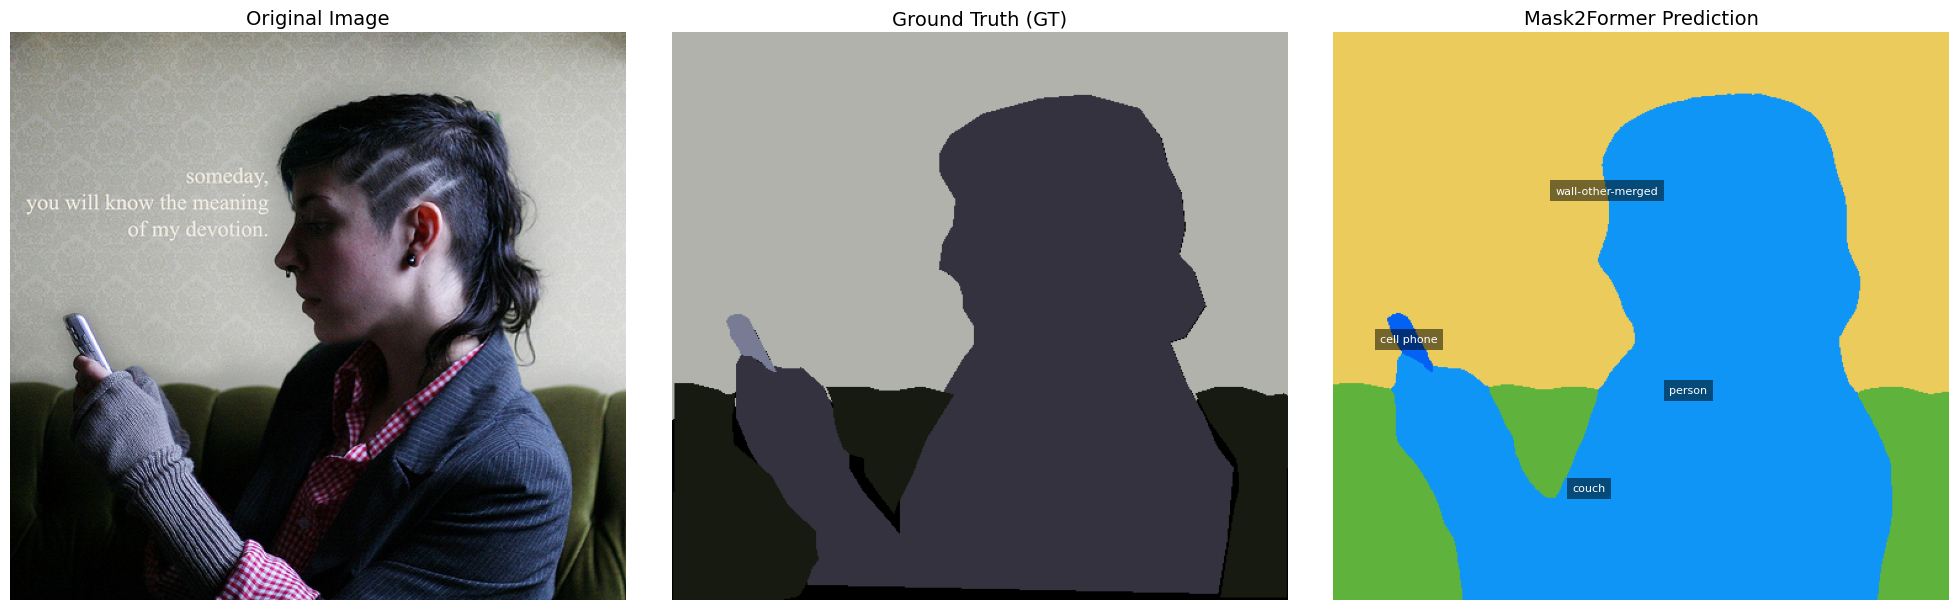

`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000579818.jpg (ID=579818)


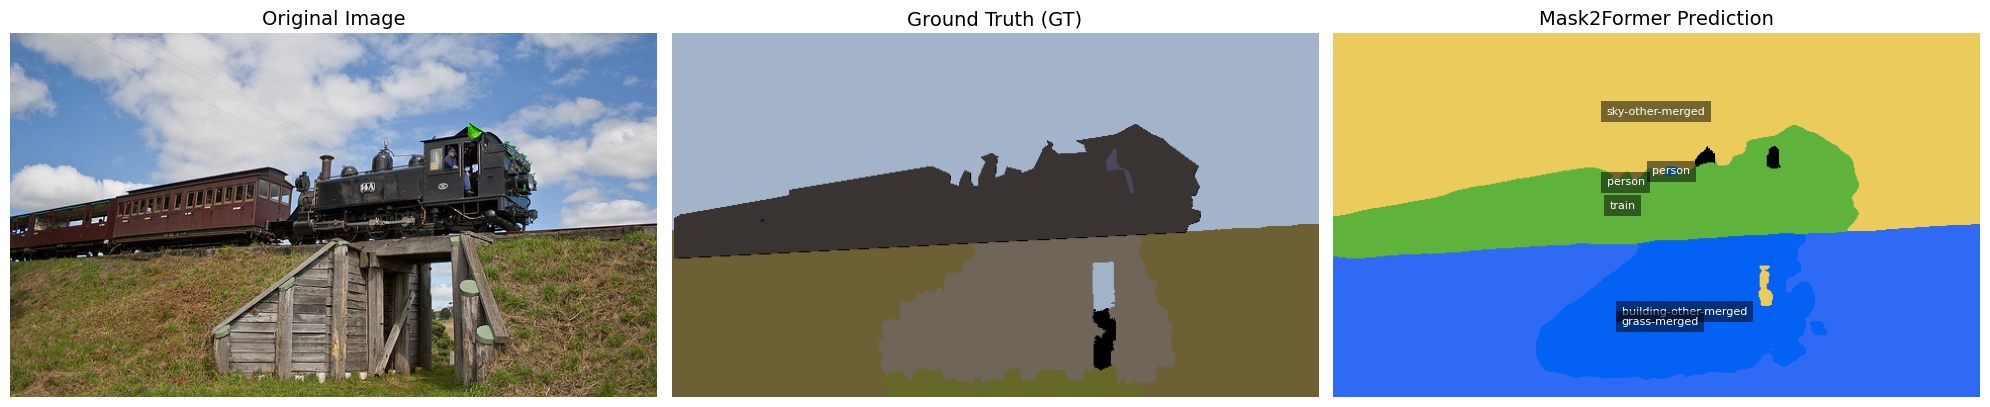

`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000001425.jpg (ID=1425)


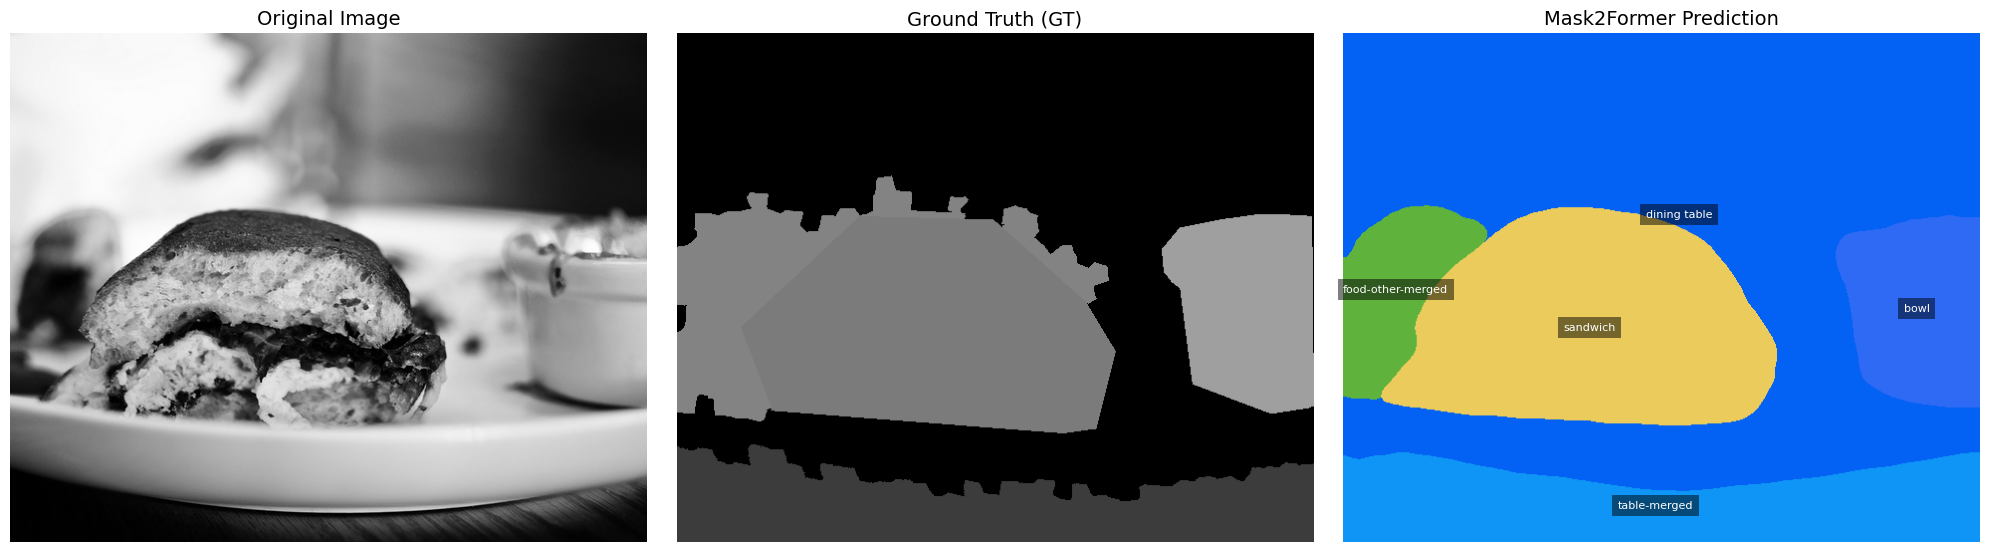

In [8]:
# Required imports
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json

from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation
from panopticapi.utils import id2rgb, rgb2id

# Load Mask2Former model
print("Loading the model...")
processor = Mask2FormerImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print("Model loaded.")

# Define paths
val_images_dir = "/content/coco/val2017"
gt_annotations_file = "/content/coco/annotations/annotations/panoptic_val2017.json"
gt_segmentation_dir = "/content/coco/annotations/annotations/panoptic_val2017"

# Load ground truth annotations
print("Loading GT annotations...")
with open(gt_annotations_file, 'r') as f:
    gt_json = json.load(f)

gt_annotations = {ann['image_id']: ann for ann in gt_json['annotations']}
print("Annotations loaded.")

# Select 3 random images to process
image_files = [f for f in os.listdir(val_images_dir) if f.endswith('.jpg')]
image_files = random.sample(image_files, 3)

# Generate random colors for segments
def random_colormap(num_classes):
    np.random.seed(42)
    colormap = np.random.randint(0, 256, size=(num_classes, 3), dtype=np.uint8)
    return colormap

colormap = random_colormap(256)  # 256 possible colors

# Loop through selected images
for img_file in image_files:
    image_id = int(img_file.split('.')[0])
    image_path = os.path.join(val_images_dir, img_file)

    print(f"\nProcessing image: {img_file} (ID={image_id})")

    # Load image
    image = Image.open(image_path).convert("RGB")

    # Load ground truth (GT)
    gt_info = gt_annotations.get(image_id, None)
    if gt_info is None:
        print(f"No GT annotation for {img_file}")
        continue

    gt_png_file = os.path.join(gt_segmentation_dir, gt_info['file_name'])
    gt_seg_display = np.array(Image.open(gt_png_file))  # fixed path

    # Model inference
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    pred_seg = prediction["segmentation"].cpu().numpy()
    segments_info = prediction["segments_info"]

    # Colorize prediction
    def colorize_segmentation_with_labels(segmentation, segments_info):
        h, w = segmentation.shape
        colored = np.zeros((h, w, 3), dtype=np.uint8)
        for segment in segments_info:
            color = colormap[segment["id"] % 256]
            mask = segmentation == segment["id"]
            colored[mask] = color
        return colored

    pred_seg_display = colorize_segmentation_with_labels(pred_seg, segments_info)

    # Overlay class labels on prediction
    def overlay_labels(ax, segments_info, segmentation):
        id2label = model.config.id2label
        for segment in segments_info:
            label_id = segment['label_id']
            label_name = id2label.get(label_id, f"ID {label_id}")
            mask = segmentation == segment['id']
            if np.sum(mask) == 0:
                continue
            y, x = np.where(mask)
            y_mean = int(np.mean(y))
            x_mean = int(np.mean(x))
            ax.text(x_mean, y_mean, label_name, color='white', fontsize=8,
                    ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5, lw=0))

    # Display results
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    axs[0].imshow(image)
    axs[0].set_title('Original Image', fontsize=14)
    axs[0].axis('off')

    axs[1].imshow(gt_seg_display)
    axs[1].set_title('Ground Truth (GT)', fontsize=14)
    axs[1].axis('off')

    axs[2].imshow(pred_seg_display)
    overlay_labels(axs[2], segments_info, pred_seg)
    axs[2].set_title('Mask2Former Prediction', fontsize=14)
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


## 1.2. Evaluation of Mask2Former on the First 500 COCO Val2017 Images

In [9]:
# Import required libraries
import os
import json
import shutil
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
from panopticapi.evaluation import pq_compute
from panopticapi.utils import IdGenerator
import random

from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation

# Load the Mask2Former model (COCO Panoptic)
print("Loading the model...")
processor = Mask2FormerImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print("Model loaded.")

# Define file paths
val_images_dir = "/content/coco/val2017"
annotation_file = "/content/coco/annotations/annotations/panoptic_val2017.json"
gt_zip = "/content/coco/annotations/annotations/panoptic_val2017.zip"

# Load ground truth COCO Panoptic annotations
print("Loading annotations...")
with open(annotation_file, 'r') as f:
    gt_json = json.load(f)

# Add missing colors if necessary
categories_list = gt_json['categories']
for cat in categories_list:
    if 'color' not in cat:
        cat['color'] = [random.randint(0, 255) for _ in range(3)]

categories = {cat['id']: cat for cat in categories_list}
id_generator = IdGenerator(categories)

# Map label_id (from Mask2Former) to category_id (COCO)
id2label = model.config.id2label
label2category = {}
for cat in categories.values():
    for label_id, name in id2label.items():
        if name == cat['name']:
            label2category[label_id] = cat['id']

print("Annotations loaded.")

# Run inference on 500 validation images
print("Starting inference on 500 images...")

image_files = sorted(os.listdir(val_images_dir))
image_files = [f for f in image_files if f.endswith('.jpg')]
image_files = image_files[:500]

# Directory to save predictions
out_dir = "/content/predictions"
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
os.makedirs(out_dir, exist_ok=True)

# Store predictions
pred_annotations = []
pred_image_ids = []

for img_file in tqdm(image_files, desc="Inference on val2017"):
    image_id = int(img_file.split('.')[0])
    image_path = os.path.join(val_images_dir, img_file)

    print(f"\nProcessing image: {img_file} (ID={image_id})")

    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

    segments_info = prediction["segments_info"]
    segmentation = prediction["segmentation"].cpu().numpy()

    # Generate RGB image in the format expected by panopticapi
    pan_format = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8)

    new_segments_info = []
    for segment in segments_info:
        label_id = segment['label_id']
        category_id = label2category.get(label_id, None)
        if category_id is None:
            continue
        segment_id, color = id_generator.get_id_and_color(category_id)
        pan_format[segmentation == segment['id']] = color

        new_segments_info.append({
            "id": segment_id,
            "category_id": category_id,
            "area": int((segmentation == segment['id']).sum()),
            "iscrowd": 0
        })

    file_name = f"pred_{image_id}.png"
    Image.fromarray(pan_format).save(os.path.join(out_dir, file_name))

    pred_annotations.append({
        "image_id": image_id,
        "file_name": file_name,
        "segments_info": new_segments_info
    })
    pred_image_ids.append(image_id)

print(f"\nNumber of predicted images: {len(pred_image_ids)}")
print("Predicted image IDs:", pred_image_ids)

# Save predictions JSON file
pred_json = {
    "annotations": pred_annotations,
    "categories": list(categories.values())
}

with open("/content/predictions/predictions.json", "w") as f:
    json.dump(pred_json, f)

print("\nPredictions saved.")

# Filter ground truth to match predicted images
print("\nFiltering ground truth...")

filtered_gt = {
    "annotations": [],
    "images": [],
    "categories": gt_json['categories']
}

gt_ann_by_id = {ann['image_id']: ann for ann in gt_json['annotations']}

for image_id in pred_image_ids:
    if image_id in gt_ann_by_id:
        filtered_gt["annotations"].append(gt_ann_by_id[image_id])
        filtered_gt["images"].append({
            "id": image_id,
            "file_name": f"{image_id:012d}.jpg"
        })

filtered_gt_file = "/content/coco/annotations/annotations/panoptic_val2017_filtered.json"
with open(filtered_gt_file, "w") as f:
    json.dump(filtered_gt, f)

print("Filtered GT saved.")

# Compute Panoptic Quality (PQ) metric
print("\nComputing Panoptic Quality metric...")

pq_res = pq_compute(
    gt_json_file=filtered_gt_file,
    gt_folder="/content/coco/annotations/annotations/panoptic_val2017",
    pred_json_file="/content/predictions/predictions.json",
    pred_folder="/content/predictions"
)

# Display final scores
print("\n=== Panoptic Quality (PQ) Evaluation Results ===")
print(f"PQ  : {pq_res['All']['pq']*100:.2f}%")
print(f"SQ  : {pq_res['All']['sq']*100:.2f}%")
print(f"RQ  : {pq_res['All']['rq']*100:.2f}%")
print(f"PQ_th (Things) : {pq_res['Things']['pq']*100:.2f}%")
print(f"PQ_st (Stuff)  : {pq_res['Stuff']['pq']*100:.2f}%")


Loading the model...
Model loaded.
Loading annotations...
Annotations loaded.
Starting inference on 500 images...


Inference on val2017:   0%|          | 0/500 [00:00<?, ?it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000000139.jpg (ID=139)


Inference on val2017:   0%|          | 2/500 [00:00<01:46,  4.68it/s]


Processing image: 000000000285.jpg (ID=285)

Processing image: 000000000632.jpg (ID=632)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   1%|          | 4/500 [00:00<01:35,  5.18it/s]


Processing image: 000000000724.jpg (ID=724)

Processing image: 000000000776.jpg (ID=776)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   1%|          | 6/500 [00:01<01:30,  5.45it/s]


Processing image: 000000000785.jpg (ID=785)

Processing image: 000000000802.jpg (ID=802)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   2%|▏         | 8/500 [00:01<01:29,  5.49it/s]


Processing image: 000000000872.jpg (ID=872)

Processing image: 000000000885.jpg (ID=885)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   2%|▏         | 10/500 [00:01<01:30,  5.39it/s]


Processing image: 000000001000.jpg (ID=1000)

Processing image: 000000001268.jpg (ID=1268)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   2%|▏         | 12/500 [00:02<01:28,  5.48it/s]


Processing image: 000000001296.jpg (ID=1296)

Processing image: 000000001353.jpg (ID=1353)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   3%|▎         | 14/500 [00:02<01:25,  5.66it/s]


Processing image: 000000001425.jpg (ID=1425)

Processing image: 000000001490.jpg (ID=1490)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   3%|▎         | 16/500 [00:02<01:20,  6.05it/s]


Processing image: 000000001503.jpg (ID=1503)

Processing image: 000000001532.jpg (ID=1532)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   4%|▎         | 18/500 [00:03<01:24,  5.68it/s]


Processing image: 000000001584.jpg (ID=1584)

Processing image: 000000001675.jpg (ID=1675)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   4%|▍         | 20/500 [00:03<01:22,  5.80it/s]


Processing image: 000000001761.jpg (ID=1761)

Processing image: 000000001818.jpg (ID=1818)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   4%|▍         | 22/500 [00:03<01:22,  5.79it/s]


Processing image: 000000001993.jpg (ID=1993)

Processing image: 000000002006.jpg (ID=2006)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   5%|▍         | 24/500 [00:04<01:22,  5.79it/s]


Processing image: 000000002149.jpg (ID=2149)

Processing image: 000000002153.jpg (ID=2153)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   5%|▌         | 26/500 [00:04<01:23,  5.71it/s]


Processing image: 000000002157.jpg (ID=2157)

Processing image: 000000002261.jpg (ID=2261)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   6%|▌         | 28/500 [00:05<01:22,  5.72it/s]


Processing image: 000000002299.jpg (ID=2299)

Processing image: 000000002431.jpg (ID=2431)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   6%|▌         | 30/500 [00:05<01:21,  5.75it/s]


Processing image: 000000002473.jpg (ID=2473)

Processing image: 000000002532.jpg (ID=2532)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   6%|▋         | 32/500 [00:05<01:18,  5.95it/s]


Processing image: 000000002587.jpg (ID=2587)

Processing image: 000000002592.jpg (ID=2592)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   7%|▋         | 33/500 [00:05<01:17,  6.03it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000002685.jpg (ID=2685)


Inference on val2017:   7%|▋         | 35/500 [00:06<01:21,  5.72it/s]


Processing image: 000000002923.jpg (ID=2923)

Processing image: 000000003156.jpg (ID=3156)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   7%|▋         | 37/500 [00:06<01:19,  5.81it/s]


Processing image: 000000003255.jpg (ID=3255)

Processing image: 000000003501.jpg (ID=3501)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   8%|▊         | 39/500 [00:06<01:19,  5.79it/s]


Processing image: 000000003553.jpg (ID=3553)

Processing image: 000000003661.jpg (ID=3661)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   8%|▊         | 41/500 [00:07<01:18,  5.82it/s]


Processing image: 000000003845.jpg (ID=3845)

Processing image: 000000003934.jpg (ID=3934)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   9%|▊         | 43/500 [00:07<01:22,  5.53it/s]


Processing image: 000000004134.jpg (ID=4134)

Processing image: 000000004395.jpg (ID=4395)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   9%|▉         | 45/500 [00:07<01:18,  5.79it/s]


Processing image: 000000004495.jpg (ID=4495)

Processing image: 000000004765.jpg (ID=4765)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:   9%|▉         | 47/500 [00:08<01:19,  5.66it/s]


Processing image: 000000004795.jpg (ID=4795)

Processing image: 000000005001.jpg (ID=5001)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  10%|▉         | 49/500 [00:08<01:22,  5.45it/s]


Processing image: 000000005037.jpg (ID=5037)

Processing image: 000000005060.jpg (ID=5060)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  10%|█         | 51/500 [00:09<01:22,  5.42it/s]


Processing image: 000000005193.jpg (ID=5193)

Processing image: 000000005477.jpg (ID=5477)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  11%|█         | 53/500 [00:09<01:18,  5.67it/s]


Processing image: 000000005503.jpg (ID=5503)

Processing image: 000000005529.jpg (ID=5529)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  11%|█         | 55/500 [00:09<01:23,  5.31it/s]


Processing image: 000000005586.jpg (ID=5586)

Processing image: 000000005600.jpg (ID=5600)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  11%|█         | 56/500 [00:10<01:24,  5.23it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000005992.jpg (ID=5992)


Inference on val2017:  11%|█▏        | 57/500 [00:10<01:28,  4.98it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000006012.jpg (ID=6012)


Inference on val2017:  12%|█▏        | 58/500 [00:10<01:31,  4.84it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000006040.jpg (ID=6040)


Inference on val2017:  12%|█▏        | 59/500 [00:10<01:31,  4.81it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000006213.jpg (ID=6213)


Inference on val2017:  12%|█▏        | 61/500 [00:11<01:32,  4.76it/s]


Processing image: 000000006460.jpg (ID=6460)

Processing image: 000000006471.jpg (ID=6471)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  13%|█▎        | 63/500 [00:11<01:31,  4.79it/s]


Processing image: 000000006614.jpg (ID=6614)

Processing image: 000000006723.jpg (ID=6723)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  13%|█▎        | 64/500 [00:11<01:33,  4.64it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000006763.jpg (ID=6763)


Inference on val2017:  13%|█▎        | 66/500 [00:12<01:31,  4.73it/s]


Processing image: 000000006771.jpg (ID=6771)

Processing image: 000000006818.jpg (ID=6818)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  14%|█▎        | 68/500 [00:12<01:23,  5.18it/s]


Processing image: 000000006894.jpg (ID=6894)

Processing image: 000000006954.jpg (ID=6954)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  14%|█▍        | 70/500 [00:12<01:20,  5.33it/s]


Processing image: 000000007088.jpg (ID=7088)

Processing image: 000000007108.jpg (ID=7108)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  14%|█▍        | 72/500 [00:13<01:17,  5.54it/s]


Processing image: 000000007278.jpg (ID=7278)

Processing image: 000000007281.jpg (ID=7281)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  15%|█▍        | 74/500 [00:13<01:15,  5.63it/s]


Processing image: 000000007386.jpg (ID=7386)

Processing image: 000000007511.jpg (ID=7511)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  15%|█▌        | 76/500 [00:13<01:17,  5.46it/s]


Processing image: 000000007574.jpg (ID=7574)

Processing image: 000000007784.jpg (ID=7784)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  16%|█▌        | 78/500 [00:14<01:14,  5.67it/s]


Processing image: 000000007795.jpg (ID=7795)

Processing image: 000000007816.jpg (ID=7816)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  16%|█▌        | 80/500 [00:14<01:16,  5.48it/s]


Processing image: 000000007818.jpg (ID=7818)

Processing image: 000000007888.jpg (ID=7888)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  16%|█▋        | 82/500 [00:15<01:14,  5.58it/s]


Processing image: 000000007977.jpg (ID=7977)

Processing image: 000000007991.jpg (ID=7991)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  17%|█▋        | 84/500 [00:15<01:13,  5.67it/s]


Processing image: 000000008021.jpg (ID=8021)

Processing image: 000000008211.jpg (ID=8211)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  17%|█▋        | 86/500 [00:15<01:14,  5.52it/s]


Processing image: 000000008277.jpg (ID=8277)

Processing image: 000000008532.jpg (ID=8532)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  18%|█▊        | 88/500 [00:16<01:13,  5.57it/s]


Processing image: 000000008629.jpg (ID=8629)

Processing image: 000000008690.jpg (ID=8690)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  18%|█▊        | 90/500 [00:16<01:14,  5.50it/s]


Processing image: 000000008762.jpg (ID=8762)

Processing image: 000000008844.jpg (ID=8844)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  18%|█▊        | 92/500 [00:16<01:13,  5.54it/s]


Processing image: 000000008899.jpg (ID=8899)

Processing image: 000000009378.jpg (ID=9378)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  19%|█▊        | 93/500 [00:17<01:13,  5.56it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000009400.jpg (ID=9400)


Inference on val2017:  19%|█▉        | 95/500 [00:17<01:14,  5.41it/s]


Processing image: 000000009448.jpg (ID=9448)

Processing image: 000000009483.jpg (ID=9483)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  19%|█▉        | 96/500 [00:17<01:14,  5.41it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000009590.jpg (ID=9590)


Inference on val2017:  20%|█▉        | 98/500 [00:17<01:15,  5.30it/s]


Processing image: 000000009769.jpg (ID=9769)

Processing image: 000000009772.jpg (ID=9772)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  20%|██        | 100/500 [00:18<01:17,  5.16it/s]


Processing image: 000000009891.jpg (ID=9891)

Processing image: 000000009914.jpg (ID=9914)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  20%|██        | 102/500 [00:18<01:14,  5.33it/s]


Processing image: 000000010092.jpg (ID=10092)

Processing image: 000000010363.jpg (ID=10363)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  21%|██        | 104/500 [00:19<01:09,  5.69it/s]


Processing image: 000000010583.jpg (ID=10583)

Processing image: 000000010707.jpg (ID=10707)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  21%|██        | 106/500 [00:19<01:10,  5.60it/s]


Processing image: 000000010764.jpg (ID=10764)

Processing image: 000000010977.jpg (ID=10977)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  22%|██▏       | 108/500 [00:19<01:08,  5.70it/s]


Processing image: 000000010995.jpg (ID=10995)

Processing image: 000000011051.jpg (ID=11051)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  22%|██▏       | 110/500 [00:20<01:09,  5.63it/s]


Processing image: 000000011122.jpg (ID=11122)

Processing image: 000000011149.jpg (ID=11149)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  22%|██▏       | 112/500 [00:20<01:11,  5.45it/s]


Processing image: 000000011197.jpg (ID=11197)

Processing image: 000000011511.jpg (ID=11511)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  23%|██▎       | 114/500 [00:20<01:10,  5.47it/s]


Processing image: 000000011615.jpg (ID=11615)

Processing image: 000000011699.jpg (ID=11699)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  23%|██▎       | 116/500 [00:21<01:09,  5.49it/s]


Processing image: 000000011760.jpg (ID=11760)

Processing image: 000000011813.jpg (ID=11813)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  24%|██▎       | 118/500 [00:21<01:06,  5.76it/s]


Processing image: 000000012062.jpg (ID=12062)

Processing image: 000000012120.jpg (ID=12120)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  24%|██▍       | 120/500 [00:22<01:15,  5.03it/s]


Processing image: 000000012280.jpg (ID=12280)

Processing image: 000000012576.jpg (ID=12576)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  24%|██▍       | 121/500 [00:22<01:20,  4.73it/s]


Processing image: 000000012639.jpg (ID=12639)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  24%|██▍       | 122/500 [00:22<02:13,  2.82it/s]


Processing image: 000000012667.jpg (ID=12667)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  25%|██▍       | 123/500 [00:23<02:44,  2.30it/s]


Processing image: 000000012670.jpg (ID=12670)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  25%|██▍       | 124/500 [00:24<02:46,  2.25it/s]


Processing image: 000000012748.jpg (ID=12748)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  25%|██▌       | 125/500 [00:24<03:04,  2.03it/s]


Processing image: 000000013004.jpg (ID=13004)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  25%|██▌       | 126/500 [00:25<03:03,  2.04it/s]


Processing image: 000000013177.jpg (ID=13177)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  25%|██▌       | 127/500 [00:25<02:47,  2.23it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000013201.jpg (ID=13201)


Inference on val2017:  26%|██▌       | 128/500 [00:25<02:25,  2.57it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000013291.jpg (ID=13291)


Inference on val2017:  26%|██▌       | 129/500 [00:25<02:07,  2.92it/s]


Processing image: 000000013348.jpg (ID=13348)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  26%|██▌       | 130/500 [00:26<01:59,  3.09it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000013546.jpg (ID=13546)


Inference on val2017:  26%|██▌       | 131/500 [00:26<01:50,  3.35it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000013597.jpg (ID=13597)


Inference on val2017:  26%|██▋       | 132/500 [00:26<01:40,  3.65it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000013659.jpg (ID=13659)


Inference on val2017:  27%|██▋       | 133/500 [00:26<01:40,  3.66it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000013729.jpg (ID=13729)


Inference on val2017:  27%|██▋       | 134/500 [00:27<01:39,  3.69it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000013774.jpg (ID=13774)


Inference on val2017:  27%|██▋       | 135/500 [00:27<01:33,  3.89it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000013923.jpg (ID=13923)


Inference on val2017:  27%|██▋       | 136/500 [00:27<01:41,  3.59it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000014007.jpg (ID=14007)


Inference on val2017:  27%|██▋       | 137/500 [00:28<01:38,  3.69it/s]


Processing image: 000000014038.jpg (ID=14038)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  28%|██▊       | 138/500 [00:28<01:49,  3.30it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000014226.jpg (ID=14226)


Inference on val2017:  28%|██▊       | 139/500 [00:28<01:48,  3.34it/s]


Processing image: 000000014380.jpg (ID=14380)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  28%|██▊       | 140/500 [00:28<01:45,  3.41it/s]


Processing image: 000000014439.jpg (ID=14439)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  28%|██▊       | 141/500 [00:29<02:01,  2.96it/s]


Processing image: 000000014473.jpg (ID=14473)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  28%|██▊       | 142/500 [00:29<01:54,  3.12it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000014831.jpg (ID=14831)


Inference on val2017:  29%|██▊       | 143/500 [00:29<01:42,  3.47it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000014888.jpg (ID=14888)


Inference on val2017:  29%|██▉       | 144/500 [00:30<01:37,  3.66it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000015079.jpg (ID=15079)


Inference on val2017:  29%|██▉       | 145/500 [00:30<01:34,  3.76it/s]


Processing image: 000000015254.jpg (ID=15254)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  29%|██▉       | 146/500 [00:30<01:39,  3.57it/s]


Processing image: 000000015272.jpg (ID=15272)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  29%|██▉       | 147/500 [00:31<02:00,  2.92it/s]


Processing image: 000000015278.jpg (ID=15278)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  30%|██▉       | 148/500 [00:31<01:57,  3.00it/s]


Processing image: 000000015335.jpg (ID=15335)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  30%|██▉       | 149/500 [00:31<01:56,  3.00it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000015338.jpg (ID=15338)


Inference on val2017:  30%|███       | 150/500 [00:32<01:55,  3.02it/s]


Processing image: 000000015440.jpg (ID=15440)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  30%|███       | 151/500 [00:32<01:50,  3.15it/s]


Processing image: 000000015497.jpg (ID=15497)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  30%|███       | 152/500 [00:32<01:46,  3.27it/s]


Processing image: 000000015517.jpg (ID=15517)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  31%|███       | 154/500 [00:33<01:31,  3.78it/s]


Processing image: 000000015597.jpg (ID=15597)

Processing image: 000000015660.jpg (ID=15660)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  31%|███       | 155/500 [00:33<01:34,  3.66it/s]


Processing image: 000000015746.jpg (ID=15746)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  31%|███       | 156/500 [00:33<01:36,  3.55it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000015751.jpg (ID=15751)


Inference on val2017:  31%|███▏      | 157/500 [00:34<01:30,  3.79it/s]


Processing image: 000000015956.jpg (ID=15956)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  32%|███▏      | 158/500 [00:34<01:37,  3.52it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000016010.jpg (ID=16010)


Inference on val2017:  32%|███▏      | 159/500 [00:34<01:31,  3.74it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000016228.jpg (ID=16228)


Inference on val2017:  32%|███▏      | 161/500 [00:34<01:17,  4.40it/s]


Processing image: 000000016249.jpg (ID=16249)

Processing image: 000000016439.jpg (ID=16439)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  32%|███▏      | 162/500 [00:35<01:11,  4.71it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000016451.jpg (ID=16451)


Inference on val2017:  33%|███▎      | 163/500 [00:35<01:14,  4.51it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000016502.jpg (ID=16502)


Inference on val2017:  33%|███▎      | 164/500 [00:35<01:12,  4.61it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000016598.jpg (ID=16598)


Inference on val2017:  33%|███▎      | 165/500 [00:35<01:12,  4.60it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000016958.jpg (ID=16958)


Inference on val2017:  33%|███▎      | 166/500 [00:36<01:14,  4.48it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000017029.jpg (ID=17029)


Inference on val2017:  34%|███▎      | 168/500 [00:36<01:12,  4.58it/s]


Processing image: 000000017031.jpg (ID=17031)

Processing image: 000000017115.jpg (ID=17115)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  34%|███▍      | 169/500 [00:36<01:14,  4.42it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000017178.jpg (ID=17178)


Inference on val2017:  34%|███▍      | 170/500 [00:36<01:16,  4.34it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000017182.jpg (ID=17182)


Inference on val2017:  34%|███▍      | 171/500 [00:37<01:15,  4.34it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000017207.jpg (ID=17207)


Inference on val2017:  35%|███▍      | 173/500 [00:37<01:11,  4.56it/s]


Processing image: 000000017379.jpg (ID=17379)

Processing image: 000000017436.jpg (ID=17436)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  35%|███▌      | 175/500 [00:38<01:06,  4.88it/s]


Processing image: 000000017627.jpg (ID=17627)

Processing image: 000000017714.jpg (ID=17714)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  35%|███▌      | 177/500 [00:38<01:03,  5.11it/s]


Processing image: 000000017899.jpg (ID=17899)

Processing image: 000000017905.jpg (ID=17905)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  36%|███▌      | 178/500 [00:38<01:01,  5.23it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000017959.jpg (ID=17959)


Inference on val2017:  36%|███▌      | 180/500 [00:38<01:02,  5.11it/s]


Processing image: 000000018150.jpg (ID=18150)

Processing image: 000000018193.jpg (ID=18193)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  36%|███▌      | 181/500 [00:39<01:00,  5.24it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000018380.jpg (ID=18380)


Inference on val2017:  37%|███▋      | 183/500 [00:39<01:02,  5.05it/s]


Processing image: 000000018491.jpg (ID=18491)

Processing image: 000000018519.jpg (ID=18519)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  37%|███▋      | 185/500 [00:39<01:01,  5.15it/s]


Processing image: 000000018575.jpg (ID=18575)

Processing image: 000000018737.jpg (ID=18737)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  37%|███▋      | 187/500 [00:40<00:57,  5.40it/s]


Processing image: 000000018770.jpg (ID=18770)

Processing image: 000000018833.jpg (ID=18833)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  38%|███▊      | 189/500 [00:40<00:57,  5.38it/s]


Processing image: 000000018837.jpg (ID=18837)

Processing image: 000000019042.jpg (ID=19042)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  38%|███▊      | 190/500 [00:40<00:57,  5.40it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000019109.jpg (ID=19109)


Inference on val2017:  38%|███▊      | 192/500 [00:41<00:57,  5.36it/s]


Processing image: 000000019221.jpg (ID=19221)

Processing image: 000000019402.jpg (ID=19402)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  39%|███▉      | 194/500 [00:41<00:57,  5.33it/s]


Processing image: 000000019432.jpg (ID=19432)

Processing image: 000000019742.jpg (ID=19742)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  39%|███▉      | 196/500 [00:41<00:55,  5.51it/s]


Processing image: 000000019786.jpg (ID=19786)

Processing image: 000000019924.jpg (ID=19924)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  40%|███▉      | 198/500 [00:42<00:53,  5.61it/s]


Processing image: 000000020059.jpg (ID=20059)

Processing image: 000000020107.jpg (ID=20107)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  40%|████      | 200/500 [00:42<00:53,  5.65it/s]


Processing image: 000000020247.jpg (ID=20247)

Processing image: 000000020333.jpg (ID=20333)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  40%|████      | 202/500 [00:43<00:54,  5.52it/s]


Processing image: 000000020553.jpg (ID=20553)

Processing image: 000000020571.jpg (ID=20571)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  41%|████      | 204/500 [00:43<00:52,  5.63it/s]


Processing image: 000000020992.jpg (ID=20992)

Processing image: 000000021167.jpg (ID=21167)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  41%|████      | 206/500 [00:43<00:50,  5.87it/s]


Processing image: 000000021465.jpg (ID=21465)

Processing image: 000000021503.jpg (ID=21503)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  42%|████▏     | 208/500 [00:44<00:51,  5.63it/s]


Processing image: 000000021604.jpg (ID=21604)

Processing image: 000000021839.jpg (ID=21839)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  42%|████▏     | 210/500 [00:44<00:53,  5.41it/s]


Processing image: 000000021879.jpg (ID=21879)

Processing image: 000000021903.jpg (ID=21903)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  42%|████▏     | 212/500 [00:44<00:53,  5.41it/s]


Processing image: 000000022192.jpg (ID=22192)

Processing image: 000000022371.jpg (ID=22371)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  43%|████▎     | 214/500 [00:45<00:50,  5.65it/s]


Processing image: 000000022396.jpg (ID=22396)

Processing image: 000000022479.jpg (ID=22479)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  43%|████▎     | 216/500 [00:45<00:50,  5.59it/s]


Processing image: 000000022589.jpg (ID=22589)

Processing image: 000000022623.jpg (ID=22623)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  44%|████▎     | 218/500 [00:45<00:50,  5.57it/s]


Processing image: 000000022705.jpg (ID=22705)

Processing image: 000000022755.jpg (ID=22755)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  44%|████▍     | 220/500 [00:46<00:50,  5.57it/s]


Processing image: 000000022892.jpg (ID=22892)

Processing image: 000000022935.jpg (ID=22935)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  44%|████▍     | 222/500 [00:46<00:48,  5.70it/s]


Processing image: 000000022969.jpg (ID=22969)

Processing image: 000000023023.jpg (ID=23023)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  45%|████▍     | 224/500 [00:46<00:49,  5.58it/s]


Processing image: 000000023034.jpg (ID=23034)

Processing image: 000000023126.jpg (ID=23126)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  45%|████▌     | 226/500 [00:47<00:49,  5.54it/s]


Processing image: 000000023230.jpg (ID=23230)

Processing image: 000000023272.jpg (ID=23272)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  46%|████▌     | 228/500 [00:47<00:49,  5.44it/s]


Processing image: 000000023359.jpg (ID=23359)


`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000023666.jpg (ID=23666)


Inference on val2017:  46%|████▌     | 229/500 [00:47<00:52,  5.13it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000023751.jpg (ID=23751)


Inference on val2017:  46%|████▌     | 230/500 [00:48<00:56,  4.79it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000023781.jpg (ID=23781)


Inference on val2017:  46%|████▌     | 231/500 [00:48<00:58,  4.63it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000023899.jpg (ID=23899)


Inference on val2017:  46%|████▋     | 232/500 [00:48<00:58,  4.59it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000023937.jpg (ID=23937)


Inference on val2017:  47%|████▋     | 233/500 [00:48<00:58,  4.57it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000024021.jpg (ID=24021)


Inference on val2017:  47%|████▋     | 234/500 [00:49<01:00,  4.39it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000024027.jpg (ID=24027)


Inference on val2017:  47%|████▋     | 235/500 [00:49<01:00,  4.38it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000024144.jpg (ID=24144)


Inference on val2017:  47%|████▋     | 236/500 [00:49<00:59,  4.44it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000024243.jpg (ID=24243)


Inference on val2017:  47%|████▋     | 237/500 [00:49<01:01,  4.29it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000024567.jpg (ID=24567)


Inference on val2017:  48%|████▊     | 238/500 [00:50<01:03,  4.15it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000024610.jpg (ID=24610)


Inference on val2017:  48%|████▊     | 240/500 [00:50<00:57,  4.51it/s]


Processing image: 000000024919.jpg (ID=24919)

Processing image: 000000025057.jpg (ID=25057)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  48%|████▊     | 242/500 [00:50<00:50,  5.08it/s]


Processing image: 000000025096.jpg (ID=25096)

Processing image: 000000025139.jpg (ID=25139)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  49%|████▉     | 244/500 [00:51<00:48,  5.32it/s]


Processing image: 000000025181.jpg (ID=25181)

Processing image: 000000025228.jpg (ID=25228)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  49%|████▉     | 246/500 [00:51<00:47,  5.36it/s]


Processing image: 000000025386.jpg (ID=25386)

Processing image: 000000025393.jpg (ID=25393)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  49%|████▉     | 247/500 [00:51<00:47,  5.29it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000025394.jpg (ID=25394)


Inference on val2017:  50%|████▉     | 249/500 [00:52<00:47,  5.24it/s]


Processing image: 000000025424.jpg (ID=25424)

Processing image: 000000025560.jpg (ID=25560)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  50%|█████     | 251/500 [00:52<00:47,  5.25it/s]


Processing image: 000000025593.jpg (ID=25593)

Processing image: 000000025603.jpg (ID=25603)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  51%|█████     | 253/500 [00:52<00:48,  5.12it/s]


Processing image: 000000025986.jpg (ID=25986)

Processing image: 000000026204.jpg (ID=26204)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  51%|█████     | 255/500 [00:53<00:45,  5.33it/s]


Processing image: 000000026465.jpg (ID=26465)

Processing image: 000000026564.jpg (ID=26564)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  51%|█████▏    | 257/500 [00:53<00:45,  5.29it/s]


Processing image: 000000026690.jpg (ID=26690)

Processing image: 000000026926.jpg (ID=26926)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  52%|█████▏    | 259/500 [00:54<00:45,  5.33it/s]


Processing image: 000000026941.jpg (ID=26941)

Processing image: 000000027186.jpg (ID=27186)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  52%|█████▏    | 260/500 [00:54<00:44,  5.45it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000027620.jpg (ID=27620)


Inference on val2017:  52%|█████▏    | 262/500 [00:54<00:44,  5.35it/s]


Processing image: 000000027696.jpg (ID=27696)

Processing image: 000000027768.jpg (ID=27768)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  53%|█████▎    | 264/500 [00:54<00:42,  5.56it/s]


Processing image: 000000027932.jpg (ID=27932)

Processing image: 000000027972.jpg (ID=27972)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  53%|█████▎    | 266/500 [00:55<00:41,  5.62it/s]


Processing image: 000000027982.jpg (ID=27982)

Processing image: 000000028285.jpg (ID=28285)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  54%|█████▎    | 268/500 [00:55<00:41,  5.55it/s]


Processing image: 000000028449.jpg (ID=28449)

Processing image: 000000028452.jpg (ID=28452)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  54%|█████▍    | 270/500 [00:56<00:41,  5.56it/s]


Processing image: 000000028809.jpg (ID=28809)

Processing image: 000000028993.jpg (ID=28993)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  54%|█████▍    | 272/500 [00:56<00:41,  5.46it/s]


Processing image: 000000029187.jpg (ID=29187)

Processing image: 000000029393.jpg (ID=29393)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  55%|█████▍    | 274/500 [00:56<00:40,  5.55it/s]


Processing image: 000000029397.jpg (ID=29397)

Processing image: 000000029596.jpg (ID=29596)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  55%|█████▌    | 275/500 [00:56<00:41,  5.44it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000029640.jpg (ID=29640)


Inference on val2017:  55%|█████▌    | 277/500 [00:57<00:42,  5.30it/s]


Processing image: 000000029675.jpg (ID=29675)

Processing image: 000000029984.jpg (ID=29984)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  56%|█████▌    | 279/500 [00:57<00:42,  5.18it/s]


Processing image: 000000030213.jpg (ID=30213)

Processing image: 000000030494.jpg (ID=30494)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  56%|█████▌    | 281/500 [00:58<00:40,  5.38it/s]


Processing image: 000000030504.jpg (ID=30504)

Processing image: 000000030675.jpg (ID=30675)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  57%|█████▋    | 283/500 [00:58<00:39,  5.46it/s]


Processing image: 000000030785.jpg (ID=30785)

Processing image: 000000030828.jpg (ID=30828)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  57%|█████▋    | 285/500 [00:58<00:38,  5.52it/s]


Processing image: 000000031050.jpg (ID=31050)

Processing image: 000000031093.jpg (ID=31093)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  57%|█████▋    | 287/500 [00:59<00:39,  5.44it/s]


Processing image: 000000031118.jpg (ID=31118)

Processing image: 000000031217.jpg (ID=31217)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  58%|█████▊    | 289/500 [00:59<00:38,  5.49it/s]


Processing image: 000000031248.jpg (ID=31248)

Processing image: 000000031269.jpg (ID=31269)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  58%|█████▊    | 290/500 [00:59<00:38,  5.41it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000031296.jpg (ID=31296)


Inference on val2017:  58%|█████▊    | 291/500 [00:59<00:41,  5.03it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000031322.jpg (ID=31322)


Inference on val2017:  58%|█████▊    | 292/500 [01:00<00:45,  4.61it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000031620.jpg (ID=31620)


Inference on val2017:  59%|█████▊    | 293/500 [01:00<00:47,  4.39it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000031735.jpg (ID=31735)


Inference on val2017:  59%|█████▉    | 294/500 [01:00<00:48,  4.26it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000031749.jpg (ID=31749)


Inference on val2017:  59%|█████▉    | 295/500 [01:00<00:48,  4.25it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000031817.jpg (ID=31817)


Inference on val2017:  59%|█████▉    | 297/500 [01:01<00:44,  4.53it/s]


Processing image: 000000032038.jpg (ID=32038)

Processing image: 000000032081.jpg (ID=32081)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  60%|█████▉    | 298/500 [01:01<00:42,  4.71it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000032285.jpg (ID=32285)


Inference on val2017:  60%|█████▉    | 299/500 [01:01<00:43,  4.63it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000032334.jpg (ID=32334)


Inference on val2017:  60%|██████    | 300/500 [01:02<00:45,  4.43it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000032570.jpg (ID=32570)


Inference on val2017:  60%|██████    | 301/500 [01:02<00:43,  4.55it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000032610.jpg (ID=32610)


Inference on val2017:  61%|██████    | 303/500 [01:02<00:42,  4.63it/s]


Processing image: 000000032735.jpg (ID=32735)

Processing image: 000000032811.jpg (ID=32811)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  61%|██████    | 305/500 [01:03<00:38,  5.09it/s]


Processing image: 000000032817.jpg (ID=32817)

Processing image: 000000032861.jpg (ID=32861)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  61%|██████▏   | 307/500 [01:03<00:36,  5.23it/s]


Processing image: 000000032887.jpg (ID=32887)

Processing image: 000000032901.jpg (ID=32901)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  62%|██████▏   | 308/500 [01:03<00:38,  5.03it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000032941.jpg (ID=32941)


Inference on val2017:  62%|██████▏   | 310/500 [01:04<00:36,  5.15it/s]


Processing image: 000000033005.jpg (ID=33005)

Processing image: 000000033104.jpg (ID=33104)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  62%|██████▏   | 312/500 [01:04<00:35,  5.27it/s]


Processing image: 000000033109.jpg (ID=33109)

Processing image: 000000033114.jpg (ID=33114)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  63%|██████▎   | 314/500 [01:04<00:34,  5.37it/s]


Processing image: 000000033221.jpg (ID=33221)

Processing image: 000000033368.jpg (ID=33368)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  63%|██████▎   | 316/500 [01:05<00:34,  5.36it/s]


Processing image: 000000033638.jpg (ID=33638)

Processing image: 000000033707.jpg (ID=33707)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  64%|██████▎   | 318/500 [01:05<00:34,  5.31it/s]


Processing image: 000000033759.jpg (ID=33759)

Processing image: 000000033854.jpg (ID=33854)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  64%|██████▍   | 320/500 [01:05<00:34,  5.27it/s]


Processing image: 000000034071.jpg (ID=34071)

Processing image: 000000034139.jpg (ID=34139)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  64%|██████▍   | 322/500 [01:06<00:33,  5.39it/s]


Processing image: 000000034205.jpg (ID=34205)

Processing image: 000000034257.jpg (ID=34257)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  65%|██████▍   | 324/500 [01:06<00:32,  5.49it/s]


Processing image: 000000034417.jpg (ID=34417)

Processing image: 000000034452.jpg (ID=34452)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  65%|██████▌   | 326/500 [01:06<00:32,  5.40it/s]


Processing image: 000000034760.jpg (ID=34760)

Processing image: 000000034873.jpg (ID=34873)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  66%|██████▌   | 328/500 [01:07<00:31,  5.45it/s]


Processing image: 000000035062.jpg (ID=35062)

Processing image: 000000035197.jpg (ID=35197)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  66%|██████▌   | 330/500 [01:07<00:31,  5.47it/s]


Processing image: 000000035279.jpg (ID=35279)

Processing image: 000000035326.jpg (ID=35326)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  66%|██████▋   | 332/500 [01:08<00:31,  5.29it/s]


Processing image: 000000035682.jpg (ID=35682)

Processing image: 000000035770.jpg (ID=35770)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  67%|██████▋   | 334/500 [01:08<00:30,  5.39it/s]


Processing image: 000000035963.jpg (ID=35963)

Processing image: 000000036494.jpg (ID=36494)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  67%|██████▋   | 336/500 [01:08<00:31,  5.29it/s]


Processing image: 000000036539.jpg (ID=36539)

Processing image: 000000036660.jpg (ID=36660)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  68%|██████▊   | 338/500 [01:09<00:29,  5.55it/s]


Processing image: 000000036678.jpg (ID=36678)

Processing image: 000000036844.jpg (ID=36844)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  68%|██████▊   | 340/500 [01:09<00:29,  5.46it/s]


Processing image: 000000036861.jpg (ID=36861)

Processing image: 000000036936.jpg (ID=36936)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  68%|██████▊   | 342/500 [01:09<00:28,  5.48it/s]


Processing image: 000000037670.jpg (ID=37670)

Processing image: 000000037689.jpg (ID=37689)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  69%|██████▊   | 343/500 [01:10<00:28,  5.51it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000037740.jpg (ID=37740)


Inference on val2017:  69%|██████▉   | 345/500 [01:10<00:28,  5.36it/s]


Processing image: 000000037751.jpg (ID=37751)

Processing image: 000000037777.jpg (ID=37777)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  69%|██████▉   | 347/500 [01:10<00:27,  5.57it/s]


Processing image: 000000037988.jpg (ID=37988)

Processing image: 000000038048.jpg (ID=38048)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  70%|██████▉   | 349/500 [01:11<00:26,  5.77it/s]


Processing image: 000000038070.jpg (ID=38070)

Processing image: 000000038118.jpg (ID=38118)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  70%|███████   | 351/500 [01:11<00:26,  5.69it/s]


Processing image: 000000038210.jpg (ID=38210)

Processing image: 000000038576.jpg (ID=38576)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  71%|███████   | 353/500 [01:11<00:26,  5.61it/s]


Processing image: 000000038678.jpg (ID=38678)

Processing image: 000000038825.jpg (ID=38825)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  71%|███████   | 354/500 [01:12<00:26,  5.60it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000038829.jpg (ID=38829)


Inference on val2017:  71%|███████   | 355/500 [01:12<00:27,  5.35it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039405.jpg (ID=39405)


Inference on val2017:  71%|███████   | 356/500 [01:12<00:27,  5.17it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039477.jpg (ID=39477)


Inference on val2017:  71%|███████▏  | 357/500 [01:12<00:29,  4.88it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039480.jpg (ID=39480)


Inference on val2017:  72%|███████▏  | 358/500 [01:12<00:29,  4.82it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039484.jpg (ID=39484)


Inference on val2017:  72%|███████▏  | 359/500 [01:13<00:31,  4.54it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039551.jpg (ID=39551)


Inference on val2017:  72%|███████▏  | 360/500 [01:13<00:30,  4.62it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039670.jpg (ID=39670)


Inference on val2017:  72%|███████▏  | 361/500 [01:13<00:31,  4.42it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039769.jpg (ID=39769)


Inference on val2017:  72%|███████▏  | 362/500 [01:13<00:31,  4.43it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039785.jpg (ID=39785)


Inference on val2017:  73%|███████▎  | 363/500 [01:14<00:30,  4.49it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039914.jpg (ID=39914)


Inference on val2017:  73%|███████▎  | 364/500 [01:14<00:31,  4.32it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039951.jpg (ID=39951)


Inference on val2017:  73%|███████▎  | 365/500 [01:14<00:31,  4.27it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000039956.jpg (ID=39956)


Inference on val2017:  73%|███████▎  | 366/500 [01:14<00:31,  4.27it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000040036.jpg (ID=40036)


Inference on val2017:  74%|███████▎  | 368/500 [01:15<00:29,  4.55it/s]


Processing image: 000000040083.jpg (ID=40083)

Processing image: 000000040471.jpg (ID=40471)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  74%|███████▍  | 370/500 [01:15<00:25,  5.01it/s]


Processing image: 000000040757.jpg (ID=40757)

Processing image: 000000041488.jpg (ID=41488)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  74%|███████▍  | 372/500 [01:15<00:23,  5.33it/s]


Processing image: 000000041633.jpg (ID=41633)

Processing image: 000000041635.jpg (ID=41635)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  75%|███████▍  | 374/500 [01:16<00:23,  5.33it/s]


Processing image: 000000041872.jpg (ID=41872)

Processing image: 000000041888.jpg (ID=41888)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  75%|███████▌  | 376/500 [01:16<00:23,  5.36it/s]


Processing image: 000000041990.jpg (ID=41990)

Processing image: 000000042070.jpg (ID=42070)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  76%|███████▌  | 378/500 [01:17<00:22,  5.53it/s]


Processing image: 000000042102.jpg (ID=42102)

Processing image: 000000042178.jpg (ID=42178)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  76%|███████▌  | 380/500 [01:17<00:21,  5.54it/s]


Processing image: 000000042276.jpg (ID=42276)

Processing image: 000000042296.jpg (ID=42296)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  76%|███████▋  | 382/500 [01:17<00:21,  5.54it/s]


Processing image: 000000042528.jpg (ID=42528)

Processing image: 000000042563.jpg (ID=42563)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  77%|███████▋  | 384/500 [01:18<00:21,  5.50it/s]


Processing image: 000000042628.jpg (ID=42628)

Processing image: 000000042888.jpg (ID=42888)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  77%|███████▋  | 386/500 [01:18<00:19,  5.74it/s]


Processing image: 000000042889.jpg (ID=42889)

Processing image: 000000043314.jpg (ID=43314)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  78%|███████▊  | 388/500 [01:18<00:19,  5.65it/s]


Processing image: 000000043435.jpg (ID=43435)

Processing image: 000000043581.jpg (ID=43581)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  78%|███████▊  | 390/500 [01:19<00:19,  5.56it/s]


Processing image: 000000043737.jpg (ID=43737)

Processing image: 000000043816.jpg (ID=43816)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  78%|███████▊  | 392/500 [01:19<00:19,  5.61it/s]


Processing image: 000000044068.jpg (ID=44068)

Processing image: 000000044195.jpg (ID=44195)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  79%|███████▉  | 394/500 [01:19<00:18,  5.70it/s]


Processing image: 000000044260.jpg (ID=44260)

Processing image: 000000044279.jpg (ID=44279)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  79%|███████▉  | 396/500 [01:20<00:18,  5.53it/s]


Processing image: 000000044590.jpg (ID=44590)

Processing image: 000000044652.jpg (ID=44652)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  80%|███████▉  | 398/500 [01:20<00:17,  5.67it/s]


Processing image: 000000044699.jpg (ID=44699)

Processing image: 000000044877.jpg (ID=44877)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  80%|████████  | 400/500 [01:20<00:18,  5.51it/s]


Processing image: 000000045070.jpg (ID=45070)

Processing image: 000000045090.jpg (ID=45090)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  80%|████████  | 401/500 [01:21<00:17,  5.72it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000045229.jpg (ID=45229)


Inference on val2017:  80%|████████  | 402/500 [01:21<00:17,  5.44it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000045472.jpg (ID=45472)


Inference on val2017:  81%|████████  | 403/500 [01:21<00:18,  5.29it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000045550.jpg (ID=45550)


Inference on val2017:  81%|████████  | 405/500 [01:21<00:18,  5.18it/s]


Processing image: 000000045596.jpg (ID=45596)

Processing image: 000000045728.jpg (ID=45728)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  81%|████████▏ | 407/500 [01:22<00:17,  5.36it/s]


Processing image: 000000046031.jpg (ID=46031)

Processing image: 000000046048.jpg (ID=46048)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  82%|████████▏ | 409/500 [01:22<00:16,  5.46it/s]


Processing image: 000000046252.jpg (ID=46252)

Processing image: 000000046378.jpg (ID=46378)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  82%|████████▏ | 411/500 [01:22<00:15,  5.72it/s]


Processing image: 000000046463.jpg (ID=46463)

Processing image: 000000046497.jpg (ID=46497)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  83%|████████▎ | 413/500 [01:23<00:15,  5.76it/s]


Processing image: 000000046804.jpg (ID=46804)

Processing image: 000000046872.jpg (ID=46872)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  83%|████████▎ | 414/500 [01:23<00:16,  5.35it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000047010.jpg (ID=47010)


Inference on val2017:  83%|████████▎ | 415/500 [01:23<00:17,  4.99it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000047112.jpg (ID=47112)


Inference on val2017:  83%|████████▎ | 416/500 [01:24<00:18,  4.46it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000047121.jpg (ID=47121)


Inference on val2017:  83%|████████▎ | 417/500 [01:24<00:18,  4.43it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000047571.jpg (ID=47571)


Inference on val2017:  84%|████████▎ | 418/500 [01:24<00:19,  4.20it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000047585.jpg (ID=47585)


Inference on val2017:  84%|████████▍ | 419/500 [01:24<00:19,  4.15it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000047740.jpg (ID=47740)


Inference on val2017:  84%|████████▍ | 420/500 [01:25<00:19,  4.19it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000047769.jpg (ID=47769)


Inference on val2017:  84%|████████▍ | 421/500 [01:25<00:18,  4.23it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000047801.jpg (ID=47801)


Inference on val2017:  84%|████████▍ | 422/500 [01:25<00:18,  4.17it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000047819.jpg (ID=47819)


Inference on val2017:  85%|████████▍ | 423/500 [01:25<00:18,  4.25it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000047828.jpg (ID=47828)


Inference on val2017:  85%|████████▍ | 424/500 [01:25<00:18,  4.16it/s]


Processing image: 000000048153.jpg (ID=48153)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  85%|████████▌ | 425/500 [01:26<00:18,  4.15it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000048396.jpg (ID=48396)


Inference on val2017:  85%|████████▌ | 426/500 [01:26<00:18,  4.05it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000048504.jpg (ID=48504)


Inference on val2017:  85%|████████▌ | 427/500 [01:26<00:18,  3.94it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000048555.jpg (ID=48555)


Inference on val2017:  86%|████████▌ | 428/500 [01:26<00:17,  4.04it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000048564.jpg (ID=48564)


Inference on val2017:  86%|████████▌ | 429/500 [01:27<00:16,  4.27it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000048924.jpg (ID=48924)


Inference on val2017:  86%|████████▌ | 430/500 [01:27<00:16,  4.35it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000049060.jpg (ID=49060)


Inference on val2017:  86%|████████▌ | 431/500 [01:27<00:15,  4.32it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000049091.jpg (ID=49091)


Inference on val2017:  86%|████████▋ | 432/500 [01:27<00:15,  4.44it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000049259.jpg (ID=49259)


Inference on val2017:  87%|████████▋ | 433/500 [01:28<00:15,  4.43it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000049269.jpg (ID=49269)


Inference on val2017:  87%|████████▋ | 434/500 [01:28<00:14,  4.45it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000049759.jpg (ID=49759)


Inference on val2017:  87%|████████▋ | 436/500 [01:28<00:13,  4.81it/s]


Processing image: 000000049761.jpg (ID=49761)

Processing image: 000000049810.jpg (ID=49810)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  87%|████████▋ | 437/500 [01:28<00:12,  5.09it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000050006.jpg (ID=50006)


Inference on val2017:  88%|████████▊ | 439/500 [01:29<00:11,  5.21it/s]


Processing image: 000000050145.jpg (ID=50145)

Processing image: 000000050149.jpg (ID=50149)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  88%|████████▊ | 441/500 [01:29<00:10,  5.48it/s]


Processing image: 000000050165.jpg (ID=50165)

Processing image: 000000050326.jpg (ID=50326)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  89%|████████▊ | 443/500 [01:29<00:10,  5.63it/s]


Processing image: 000000050331.jpg (ID=50331)

Processing image: 000000050380.jpg (ID=50380)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  89%|████████▉ | 445/500 [01:30<00:09,  5.50it/s]


Processing image: 000000050638.jpg (ID=50638)

Processing image: 000000050679.jpg (ID=50679)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  89%|████████▉ | 447/500 [01:30<00:09,  5.37it/s]


Processing image: 000000050811.jpg (ID=50811)

Processing image: 000000050828.jpg (ID=50828)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  90%|████████▉ | 449/500 [01:31<00:09,  5.59it/s]


Processing image: 000000050844.jpg (ID=50844)

Processing image: 000000050896.jpg (ID=50896)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  90%|█████████ | 451/500 [01:31<00:08,  5.69it/s]


Processing image: 000000050943.jpg (ID=50943)

Processing image: 000000051008.jpg (ID=51008)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  91%|█████████ | 453/500 [01:31<00:08,  5.74it/s]


Processing image: 000000051309.jpg (ID=51309)

Processing image: 000000051314.jpg (ID=51314)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  91%|█████████ | 455/500 [01:32<00:07,  5.70it/s]


Processing image: 000000051326.jpg (ID=51326)

Processing image: 000000051598.jpg (ID=51598)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  91%|█████████▏| 457/500 [01:32<00:07,  5.74it/s]


Processing image: 000000051610.jpg (ID=51610)

Processing image: 000000051712.jpg (ID=51712)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  92%|█████████▏| 459/500 [01:32<00:07,  5.80it/s]


Processing image: 000000051738.jpg (ID=51738)

Processing image: 000000051938.jpg (ID=51938)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  92%|█████████▏| 461/500 [01:33<00:06,  5.73it/s]


Processing image: 000000051961.jpg (ID=51961)

Processing image: 000000051976.jpg (ID=51976)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  93%|█████████▎| 463/500 [01:33<00:06,  5.63it/s]


Processing image: 000000052007.jpg (ID=52007)

Processing image: 000000052017.jpg (ID=52017)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  93%|█████████▎| 465/500 [01:33<00:06,  5.58it/s]


Processing image: 000000052412.jpg (ID=52412)

Processing image: 000000052413.jpg (ID=52413)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  93%|█████████▎| 467/500 [01:34<00:05,  5.67it/s]


Processing image: 000000052462.jpg (ID=52462)

Processing image: 000000052507.jpg (ID=52507)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  94%|█████████▍| 469/500 [01:34<00:05,  5.68it/s]


Processing image: 000000052565.jpg (ID=52565)

Processing image: 000000052591.jpg (ID=52591)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  94%|█████████▍| 471/500 [01:34<00:05,  5.73it/s]


Processing image: 000000052891.jpg (ID=52891)

Processing image: 000000052996.jpg (ID=52996)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  95%|█████████▍| 473/500 [01:35<00:05,  5.33it/s]


Processing image: 000000053505.jpg (ID=53505)

Processing image: 000000053529.jpg (ID=53529)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  95%|█████████▌| 475/500 [01:35<00:04,  5.47it/s]


Processing image: 000000053624.jpg (ID=53624)

Processing image: 000000053626.jpg (ID=53626)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  95%|█████████▌| 477/500 [01:36<00:04,  5.46it/s]


Processing image: 000000053909.jpg (ID=53909)

Processing image: 000000053994.jpg (ID=53994)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  96%|█████████▌| 479/500 [01:36<00:03,  5.48it/s]


Processing image: 000000054123.jpg (ID=54123)

Processing image: 000000054164.jpg (ID=54164)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  96%|█████████▌| 481/500 [01:36<00:03,  5.64it/s]


Processing image: 000000054592.jpg (ID=54592)

Processing image: 000000054593.jpg (ID=54593)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  96%|█████████▋| 482/500 [01:36<00:03,  5.54it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000054605.jpg (ID=54605)


Inference on val2017:  97%|█████████▋| 484/500 [01:37<00:03,  5.23it/s]


Processing image: 000000054628.jpg (ID=54628)

Processing image: 000000054654.jpg (ID=54654)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  97%|█████████▋| 486/500 [01:37<00:02,  5.34it/s]


Processing image: 000000054931.jpg (ID=54931)

Processing image: 000000054967.jpg (ID=54967)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  98%|█████████▊| 488/500 [01:38<00:02,  5.48it/s]


Processing image: 000000055002.jpg (ID=55002)

Processing image: 000000055022.jpg (ID=55022)


`label_ids_to_fuse` unset. No instance will be fused.
Inference on val2017:  98%|█████████▊| 489/500 [01:38<00:02,  5.41it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000055072.jpg (ID=55072)


Inference on val2017:  98%|█████████▊| 490/500 [01:38<00:01,  5.10it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000055150.jpg (ID=55150)


Inference on val2017:  98%|█████████▊| 491/500 [01:38<00:01,  4.77it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000055167.jpg (ID=55167)


Inference on val2017:  98%|█████████▊| 492/500 [01:38<00:01,  4.58it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000055299.jpg (ID=55299)


Inference on val2017:  99%|█████████▊| 493/500 [01:39<00:01,  4.49it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000055528.jpg (ID=55528)


Inference on val2017:  99%|█████████▉| 494/500 [01:39<00:01,  4.45it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000055950.jpg (ID=55950)


Inference on val2017:  99%|█████████▉| 495/500 [01:39<00:01,  4.51it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000056127.jpg (ID=56127)


Inference on val2017:  99%|█████████▉| 496/500 [01:39<00:00,  4.34it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000056288.jpg (ID=56288)


Inference on val2017:  99%|█████████▉| 497/500 [01:40<00:00,  4.35it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000056344.jpg (ID=56344)


Inference on val2017: 100%|█████████▉| 498/500 [01:40<00:00,  4.37it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000056350.jpg (ID=56350)


Inference on val2017: 100%|█████████▉| 499/500 [01:40<00:00,  4.13it/s]`label_ids_to_fuse` unset. No instance will be fused.



Processing image: 000000056545.jpg (ID=56545)


Inference on val2017: 100%|██████████| 500/500 [01:40<00:00,  4.96it/s]



Number of predicted images: 500
Predicted image IDs: [139, 285, 632, 724, 776, 785, 802, 872, 885, 1000, 1268, 1296, 1353, 1425, 1490, 1503, 1532, 1584, 1675, 1761, 1818, 1993, 2006, 2149, 2153, 2157, 2261, 2299, 2431, 2473, 2532, 2587, 2592, 2685, 2923, 3156, 3255, 3501, 3553, 3661, 3845, 3934, 4134, 4395, 4495, 4765, 4795, 5001, 5037, 5060, 5193, 5477, 5503, 5529, 5586, 5600, 5992, 6012, 6040, 6213, 6460, 6471, 6614, 6723, 6763, 6771, 6818, 6894, 6954, 7088, 7108, 7278, 7281, 7386, 7511, 7574, 7784, 7795, 7816, 7818, 7888, 7977, 7991, 8021, 8211, 8277, 8532, 8629, 8690, 8762, 8844, 8899, 9378, 9400, 9448, 9483, 9590, 9769, 9772, 9891, 9914, 10092, 10363, 10583, 10707, 10764, 10977, 10995, 11051, 11122, 11149, 11197, 11511, 11615, 11699, 11760, 11813, 12062, 12120, 12280, 12576, 12639, 12667, 12670, 12748, 13004, 13177, 13201, 13291, 13348, 13546, 13597, 13659, 13729, 13774, 13923, 14007, 14038, 14226, 14380, 14439, 14473, 14831, 14888, 15079, 15254, 15272, 15278, 15335, 15338, 15440

## 1.3. Algorithm Evaluation on a YouTube Video

In [ ]:
# Download a YouTube Video Using yt-dlp

# Install yt-dlp (more reliable than pytube)
!pip install -U yt-dlp

# Define the video URL
url = 'https://www.youtube.com/watch?v=y9bSsSeJUnY'  # Replace with your own link

# Download the video in best quality
!yt-dlp -f best -o "video.mp4" {url}

print("Download completed.")


In [13]:
# Import necessary libraries
import cv2
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation
from IPython.display import Video, display

# Video configuration
VIDEO_INPUT = "/content/video.mp4"  # Input video path
VIDEO_OUTPUT = "/content/output_segmented.mp4"  # Output video path
FRAME_SKIP = 3  # Process one frame out of every 3 to speed up
QUALITY = 90  # Placeholder (not used directly)

# Initialize video capture
cap = cv2.VideoCapture(VIDEO_INPUT)
if not cap.isOpened():
    raise ValueError(f"Cannot open {VIDEO_INPUT}")

# Retrieve video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize video writer (codec 'mp4v' is browser-compatible)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps_out = fps / FRAME_SKIP if FRAME_SKIP > 0 else fps
out = cv2.VideoWriter(VIDEO_OUTPUT, fourcc, fps_out, (width, height))

# Load the Mask2Former model (GPU required)
device = torch.device("cuda")
if not torch.cuda.is_available():
    raise RuntimeError("No GPU available. Please enable hardware acceleration in Colab.")

# Load processor and model pre-trained on COCO panoptic
processor = Mask2FormerImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-coco-panoptic"
).to(device)

# Function to perform panoptic segmentation on a single frame
def process_frame(frame):
    # Convert BGR to RGB and prepare tensor input
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    inputs = processor(images=pil_image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Return processed segmentation output
    return processor.post_process_panoptic_segmentation(outputs, target_sizes=[(height, width)])[0]

# Function to overlay segmentation masks and labels on the frame
def overlay_segmentation(frame, prediction):
    segmentation = prediction["segmentation"].cpu().numpy()
    seg_mask = np.zeros((*segmentation.shape, 3), dtype=np.uint8)

    # Apply random colors to each segment
    for segment in prediction["segments_info"]:
        color = np.random.randint(0, 256, 3)
        seg_mask[segmentation == segment["id"]] = color

    # Blend segmentation mask with the original frame
    blended = cv2.addWeighted(frame, 0.7, seg_mask, 0.3, 0)

    # Draw labels at the center of each segment
    for segment in prediction["segments_info"]:
        mask = segmentation == segment["id"]
        if mask.sum() > 100:  # Avoid labeling very small segments
            y, x = np.where(mask)
            x_center, y_center = int(np.mean(x)), int(np.mean(y))
            label = model.config.id2label[segment["label_id"]]
            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(blended, (x_center-w//2-2, y_center-h//2-2),
                          (x_center+w//2+2, y_center+h//2+2), (0, 0, 0), -1)
            cv2.putText(blended, label, (x_center-w//2, y_center+h//2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return blended

# Main video processing loop
print(f"Processing video ({total_frames} frames)...")

try:
    for i in tqdm(range(total_frames), desc="Processing"):
        ret, frame = cap.read()
        if not ret:
            break

        # Skip frames to reduce processing time
        if i % FRAME_SKIP != 0:
            continue

        # Run inference and draw results
        prediction = process_frame(frame)
        result_frame = overlay_segmentation(frame, prediction)

        # Write the processed frame to output video
        out.write(result_frame)

finally:
    cap.release()
    out.release()
    print(f"\nProcessed video saved to: {VIDEO_OUTPUT}")

# Display the final video inside the notebook
display(Video(VIDEO_OUTPUT, embed=True))


ValueError: Cannot open /content/video.mp4

# 2. FPN algorithm
## 2.1. Inference on three random COCO Validation Images


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 99.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.

model_final_c10459.pkl: 184MB [00:00, 247MB/s]                           


Running inference on 3 random COCO val2017 images...


/usr/local/lib/python3.11/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


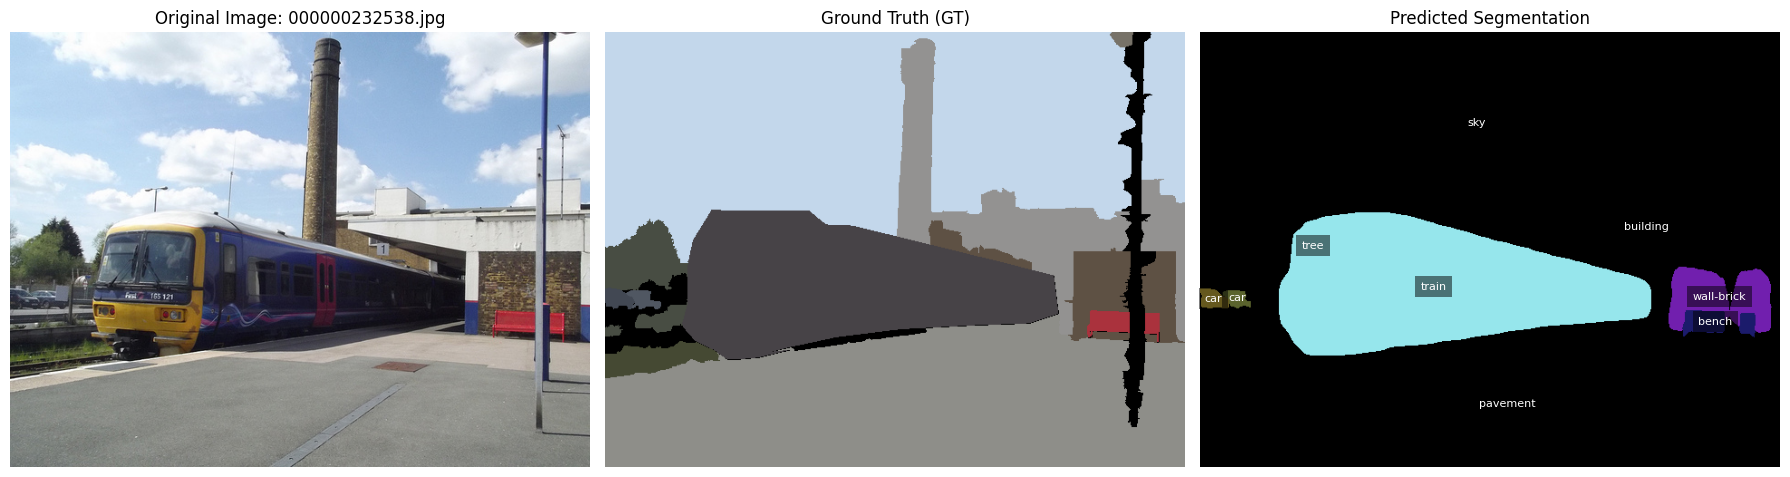

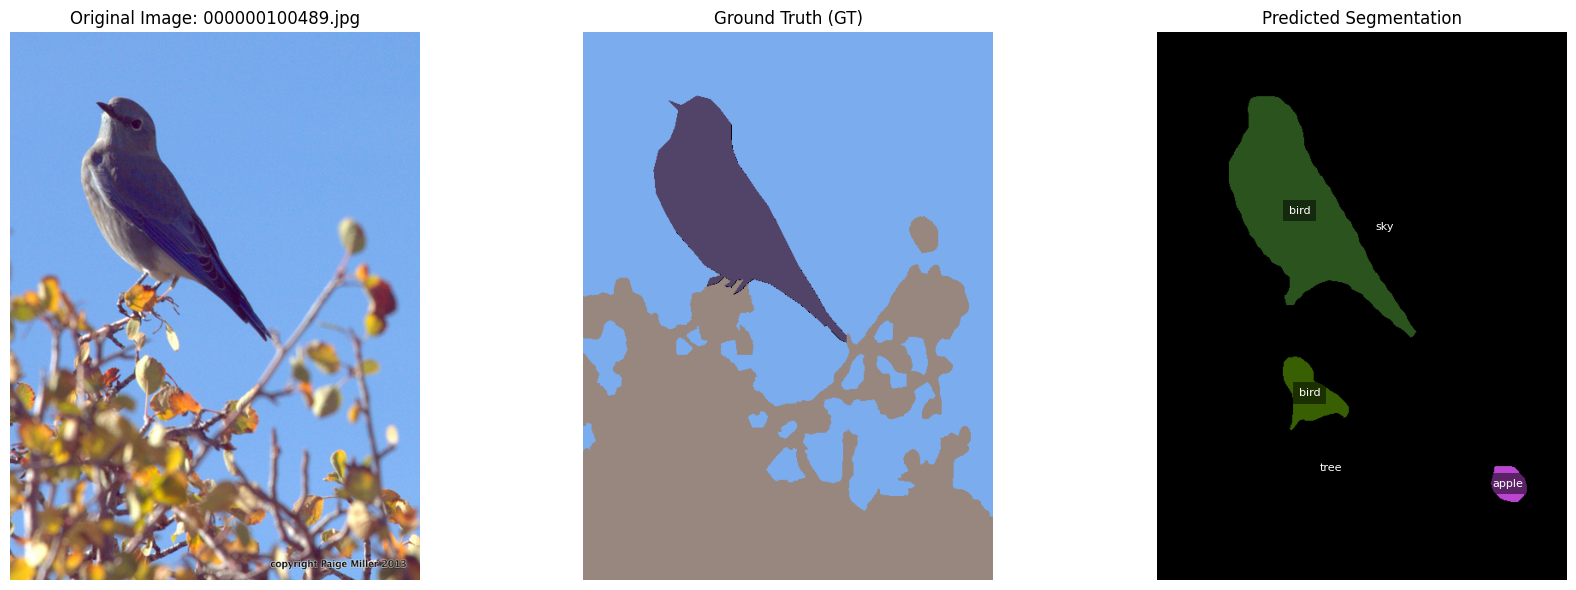

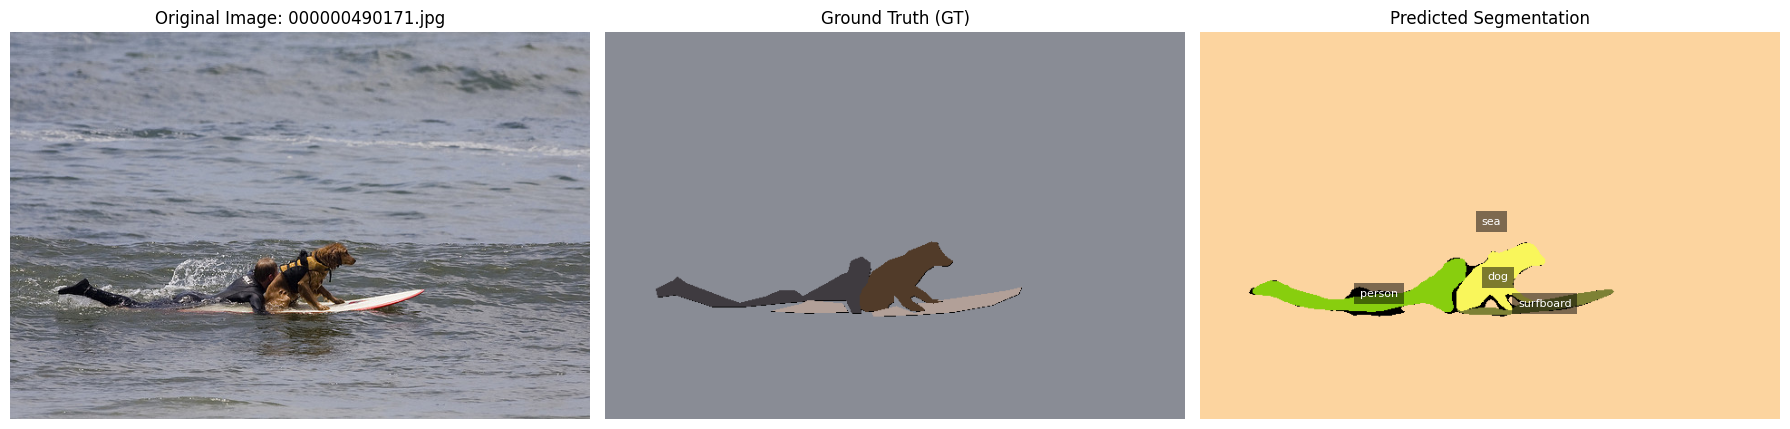

In [7]:
# Install compatible CPU dependencies
!pip install -q torch torchvision torchaudio
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q git+https://github.com/cocodataset/panopticapi.git
!pip install -q opencv-python pillow

# Imports
import os
import json
import shutil
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import torch
import random

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog

from panopticapi.utils import IdGenerator
from panopticapi.evaluation import pq_compute

# Custom paths
val_images_dir = "/content/coco/val2017"
gt_annotations_file = "/content/coco/annotations/annotations/panoptic_val2017.json"
gt_segmentation_dir = "/content/coco/annotations/annotations/panoptic_val2017"
out_dir = "/content/predictions_detectron2"
out_json_file = f"{out_dir}/predictions.json"
filtered_gt_file = "/content/coco/annotations/annotations/panoptic_val2017_filtered.json"

# Create output directory
os.makedirs(out_dir, exist_ok=True)

# Load ground truth annotations
with open(gt_annotations_file, "r") as f:
    gt_json = json.load(f)

categories = gt_json["categories"]

# Add random colors if missing
for cat in categories:
    if "color" not in cat:
        cat["color"] = [int(x) for x in np.random.randint(0, 256, size=3)]

categories_by_name = {cat["name"]: cat for cat in categories}
id_generator = IdGenerator({cat["id"]: cat for cat in categories})

gt_annotations = {ann["image_id"]: ann for ann in gt_json["annotations"]}
images_info = {img["id"]: img["file_name"] for img in gt_json["images"]}

# Load Detectron2 model (CPU or GPU)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# Inference and visualization on 3 random images
print("Running inference on 3 random COCO val2017 images...")

import matplotlib.pyplot as plt

image_files = [f for f in os.listdir(val_images_dir) if f.endswith('.jpg')]
image_files = random.sample(image_files, 3)

for file_name in image_files:
    image_id = int(file_name.split(".")[0])
    if image_id not in gt_annotations:
        continue

    img_path = os.path.join(val_images_dir, file_name)
    image = cv2.imread(img_path)
    if image is None:
        continue

    # Predict segmentation
    output = predictor(image)
    pan_seg, segments_info = output["panoptic_seg"]
    pan_seg = pan_seg.cpu().numpy()

    # Generate colored predicted image
    pan_rgb = np.zeros((pan_seg.shape[0], pan_seg.shape[1], 3), dtype=np.uint8)
    for segment in segments_info:
        if segment["isthing"]:
            cat_name = metadata.thing_classes[segment["category_id"]]
        else:
            cat_name = metadata.stuff_classes[segment["category_id"]]
        category_id = categories_by_name.get(cat_name, {}).get("id", None)
        if category_id is None:
            continue
        seg_id, color = id_generator.get_id_and_color(category_id)
        pan_rgb[pan_seg == segment["id"]] = color

    # Load ground truth segmentation
    gt_ann = gt_annotations.get(image_id, None)
    if gt_ann is None:
        print(f"No annotation for image {file_name}")
        continue
    gt_file = os.path.join(gt_segmentation_dir, gt_ann["file_name"])
    gt_img = np.array(Image.open(gt_file))

    # Display results using matplotlib
    plt.figure(figsize=(18, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image: {file_name}")
    plt.axis("off")

    # Ground truth
    plt.subplot(1, 3, 2)
    plt.imshow(gt_img)
    plt.title("Ground Truth (GT)")
    plt.axis("off")

    # Predicted segmentation
    plt.subplot(1, 3, 3)
    plt.imshow(pan_rgb)
    plt.title("Predicted Segmentation")

    # Add labels to predicted segments
    for segment in segments_info:
        mask = pan_seg == segment["id"]
        if np.sum(mask) == 0:
            continue
        y, x = np.where(mask)
        y_mean = int(np.mean(y))
        x_mean = int(np.mean(x))
        if segment["isthing"]:
            label = metadata.thing_classes[segment["category_id"]]
        else:
            label = metadata.stuff_classes[segment["category_id"]]
        plt.text(x_mean, y_mean, label, color='white', fontsize=8,
                 ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5, lw=0))

    plt.axis("off")
    plt.tight_layout()
    plt.show()


## 2.2. Evaluation of FPN on the First 500 COCO Val2017 Images




In [12]:
# Install CPU-compatible dependencies
# !pip install -q torch torchvision torchaudio
# !pip install -q git+https://github.com/facebookresearch/detectron2.git
# !pip install -q git+https://github.com/cocodataset/panopticapi.git
# !pip install -q opencv-python pillow

# Imports
import os
import json
import shutil
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import torch

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog

from panopticapi.utils import IdGenerator
from panopticapi.evaluation import pq_compute

# Define paths
val_images_dir = "/content/coco/val2017"
gt_annotations_file = "/content/coco/annotations/annotations/panoptic_val2017.json"
gt_segmentation_dir = "/content/coco/annotations/annotations/panoptic_val2017"
out_dir = "/content/predictions_detectron2"
out_json_file = f"{out_dir}/predictions.json"
filtered_gt_file = "/content/coco/annotations/annotations/panoptic_val2017_filtered.json"

# Create output directory
os.makedirs(out_dir, exist_ok=True)

# Load ground truth annotations
with open(gt_annotations_file, "r") as f:
    gt_json = json.load(f)

categories = gt_json["categories"]

# Add random colors to categories if not already defined
for cat in categories:
    if "color" not in cat:
        cat["color"] = [int(x) for x in np.random.randint(0, 256, size=3)]

categories_by_name = {cat["name"]: cat for cat in categories}
id_generator = IdGenerator({cat["id"]: cat for cat in categories})

gt_annotations = {ann["image_id"]: ann for ann in gt_json["annotations"]}
images_info = {img["id"]: img["file_name"] for img in gt_json["images"]}

# Load Detectron2 model (runs on CPU or GPU)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# Inference
print("Running inference on COCO val2017 images...")

pred_annotations = []
used_image_ids = []

image_files = sorted(os.listdir(val_images_dir))
image_files = [f for f in image_files if f.endswith(".jpg")]
image_files = image_files[:500]  # Reduce number for CPU execution

for file_name in tqdm(image_files, desc="Processing"):
    image_id = int(file_name.split(".")[0])
    if image_id not in gt_annotations:
        continue

    img_path = os.path.join(val_images_dir, file_name)
    image = cv2.imread(img_path)
    if image is None:
        continue

    output = predictor(image)
    pan_seg, segments_info = output["panoptic_seg"]
    pan_seg = pan_seg.cpu().numpy()

    pan_rgb = np.zeros((pan_seg.shape[0], pan_seg.shape[1], 3), dtype=np.uint8)
    new_segments_info = []

    for segment in segments_info:
        if segment["isthing"]:
            cat_name = metadata.thing_classes[segment["category_id"]]
        else:
            cat_name = metadata.stuff_classes[segment["category_id"]]
        category_id = categories_by_name.get(cat_name, {}).get("id", None)
        if category_id is None:
            continue

        seg_id, color = id_generator.get_id_and_color(category_id)
        pan_rgb[pan_seg == segment["id"]] = color

        new_segments_info.append({
            "id": seg_id,
            "category_id": category_id,
            "area": int((pan_seg == segment["id"]).sum()),
            "iscrowd": 0
        })

    out_png = f"pred_{image_id}.png"
    Image.fromarray(pan_rgb).save(f"{out_dir}/{out_png}")

    pred_annotations.append({
        "image_id": image_id,
        "file_name": out_png,
        "segments_info": new_segments_info
    })
    used_image_ids.append(image_id)

# Save predictions to JSON
pred_json = {
    "annotations": pred_annotations,
    "categories": categories
}
with open(out_json_file, "w") as f:
    json.dump(pred_json, f)

# Filter ground truth to match predicted images
filtered_gt = {
    "images": [{"id": img_id, "file_name": images_info[img_id]} for img_id in used_image_ids],
    "annotations": [gt_annotations[img_id] for img_id in used_image_ids],
    "categories": categories
}
with open(filtered_gt_file, "w") as f:
    json.dump(filtered_gt, f)

# Evaluate predictions using panopticapi (PQ / SQ / RQ)
print("Computing PQ metrics with panopticapi...")

results = pq_compute(
    gt_json_file=filtered_gt_file,
    gt_folder=gt_segmentation_dir,
    pred_json_file=out_json_file,
    pred_folder=out_dir
)

# Display evaluation results
print("\n=== Panoptic Quality Evaluation Results (Detectron2 / CPU or GPU) ===")
print(f"PQ  : {results['All']['pq']*100:.2f}%")
print(f"SQ  : {results['All']['sq']*100:.2f}%")
print(f"RQ  : {results['All']['rq']*100:.2f}%")
print(f"PQ_th (Things) : {results['Things']['pq']*100:.2f}%")
print(f"PQ_st (Stuff)  : {results['Stuff']['pq']*100:.2f}%")


Inférence sur les images COCO val2017...


Traitement: 100%|██████████| 500/500 [01:32<00:00,  5.42it/s]


Calcul des métriques PQ avec panopticapi...
Evaluation panoptic segmentation metrics:
Ground truth:
	Segmentation folder: /content/coco/annotations/annotations/panoptic_val2017
	JSON file: /content/coco/annotations/annotations/panoptic_val2017_filtered.json
Prediction:
	Segmentation folder: /content/predictions_detectron2
	JSON file: /content/predictions_detectron2/predictions.json
Number of cores: 2, images per core: 250
Core: 0, 0 from 250 images processed
Core: 1, 0 from 250 images processed
Core: 0, 100 from 250 images processed
Core: 1, 100 from 250 images processed
Core: 1, 200 from 250 images processed
Core: 0, 200 from 250 images processed
Core: 1, all 250 images processed
Core: 0, all 250 images processed
          |    PQ     SQ     RQ     N
--------------------------------------
All       |  37.0   64.0   44.6   131
Things    |  51.0   80.7   60.9    78
Stuff     |  16.6   39.4   20.6    53
Time elapsed: 4.69 seconds

=== Résultats Panoptic Quality (Detectron2 / CPU ou GPU) 